In [0]:
import os
import json 
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import *
from music21 import *
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [0]:
data_directory = "./drive/My Drive/Data/"
data_file = "Data_Tunes.txt"
charIndex_json = "char_to_index.json"
BATCH_SIZE = 16
SEQ_LENGTH = 64

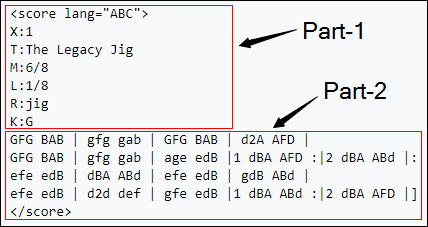

In [10]:
Image(filename='./drive/My Drive/abc.png')

ABC Notation

ABC notation of Music
There are two parts in ABC-notation.

Part-1 represents meta data. Lines in the Part-1 of the tune notation, beginning with a letter followed by a colon, indicate various aspects of the tune such as the index, when there are more than one tune in a file (X:), the title (T:), the time signature (M:), the default note length (L:), the type of tune (R:) and the key (K:).

Part-2 represents the tune, which is a sequence of characters where each character represents some musical note.

In [0]:
# Function to remove Part-1 of  and append a start token i.e 'Z' for each tune in the dataset

def preprocess(data):
  list1=list(data)
  list2=['\n','\n','\n']
  ignore=['X','T','M','S','K','P']
  i=0
  #to remove Part1:
  while(i<len(list1)):
    if(((list1[i] in ignore) and (list1[i+1]==":"))or list1[i]=='%' ):
      del list2[-1]
      while(list1[i]!='\n'):
        i=i+1
    list2.append(list1[i])
    i=i+1
  i=0
  #to append 'Z'(start token)
  preprocess_data=[]
  while(i<len(list2)):
    if(list2[i]=='\n'and list2[i+1]=='\n' and list2[i+2]=='\n'):
      preprocess_data.append('Z')
      i=i+3
    else:
      preprocess_data.append(list2[i])
      i=i+1
  return preprocess_data


In [0]:
# Function to create char_to_index and index_to_char dictionaries so as to map each character to an index and vice versa.
# Returns all_characters_as_indices i.e an array containing all characters of the dataset replaced with their corresponding indices as per the vocabulary.
# Also returns num_unique_chars i.e an integer equal to number of unique characters in the data.

def read_data(preprocess_data):
  char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(preprocess_data))))}

    
  with open(os.path.join(data_directory, charIndex_json), mode = "w") as f:
        json.dump(char_to_index, f)
        
  index_to_char = {i: ch for (ch, i) in char_to_index.items()}
  num_unique_chars = len(char_to_index)
  all_characters_as_indices = np.asarray([char_to_index[c] for c in preprocess_data], dtype = np.int32)
  return all_characters_as_indices,num_unique_chars



In [0]:
# Function which returns X and Y which will be used as input and target output for training the model.

def input_output(all_chars_as_indices,num_unique_chars):
    total_length = all_chars_as_indices.shape[0]
    num_examples=int(total_length/SEQ_LENGTH)
    X=np.zeros((num_examples,SEQ_LENGTH))
    Y=np.zeros((num_examples,SEQ_LENGTH,num_unique_chars))
    for i in range(num_examples):
      for j in range(SEQ_LENGTH):
        X[i,j]=all_chars_as_indices[i*SEQ_LENGTH+j]
        Y[i,j,all_chars_as_indices[i*SEQ_LENGTH+j+1]]=1
    return X,Y

In [0]:
# Function to build the training model

def build_model( seq_length, num_unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, input_shape = (seq_length,))) 
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
    
    model.add(TimeDistributed(Dense(num_unique_chars)))

    model.add(Activation("softmax"))
    
    return model

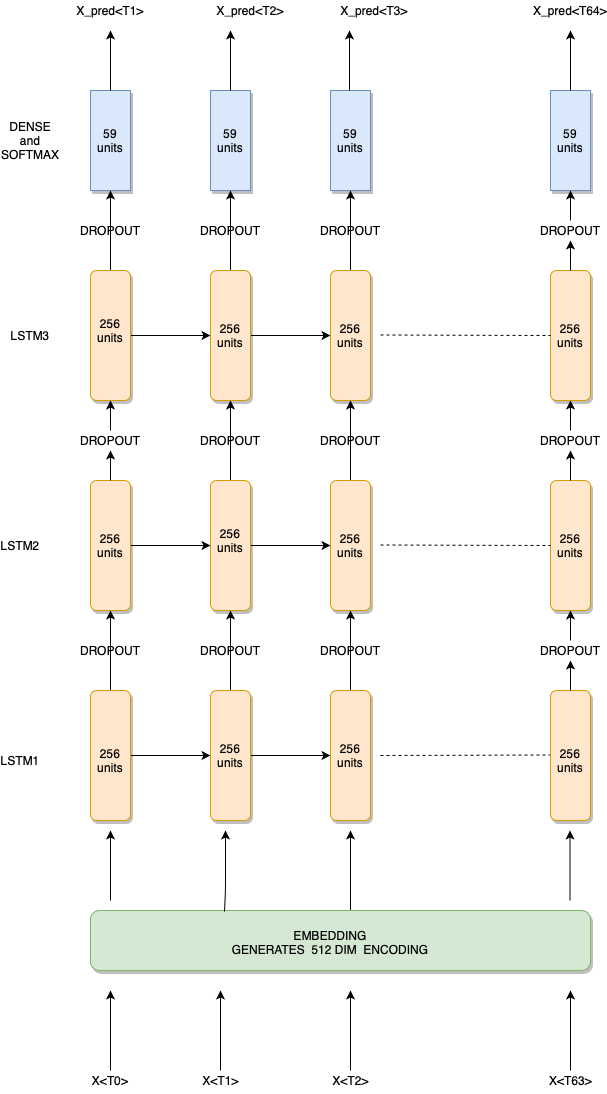

In [15]:
Image(filename='./drive/My Drive/build.png') #image of training model

stateful:

 If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.

In [0]:
#Function which builds model for generating music sequences.

def make_model(num_unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = num_unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 
  
# stateful: If True, the last state for each sample at index i in a batch will be used 
# as initial state for the sample of index i in the following batch.
    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256,return_sequences=True, stateful = True)) 
    model.add(Dropout(0.2))
    
    model.add((Dense(num_unique_chars)))
    model.add(Activation("softmax"))
    
    return model

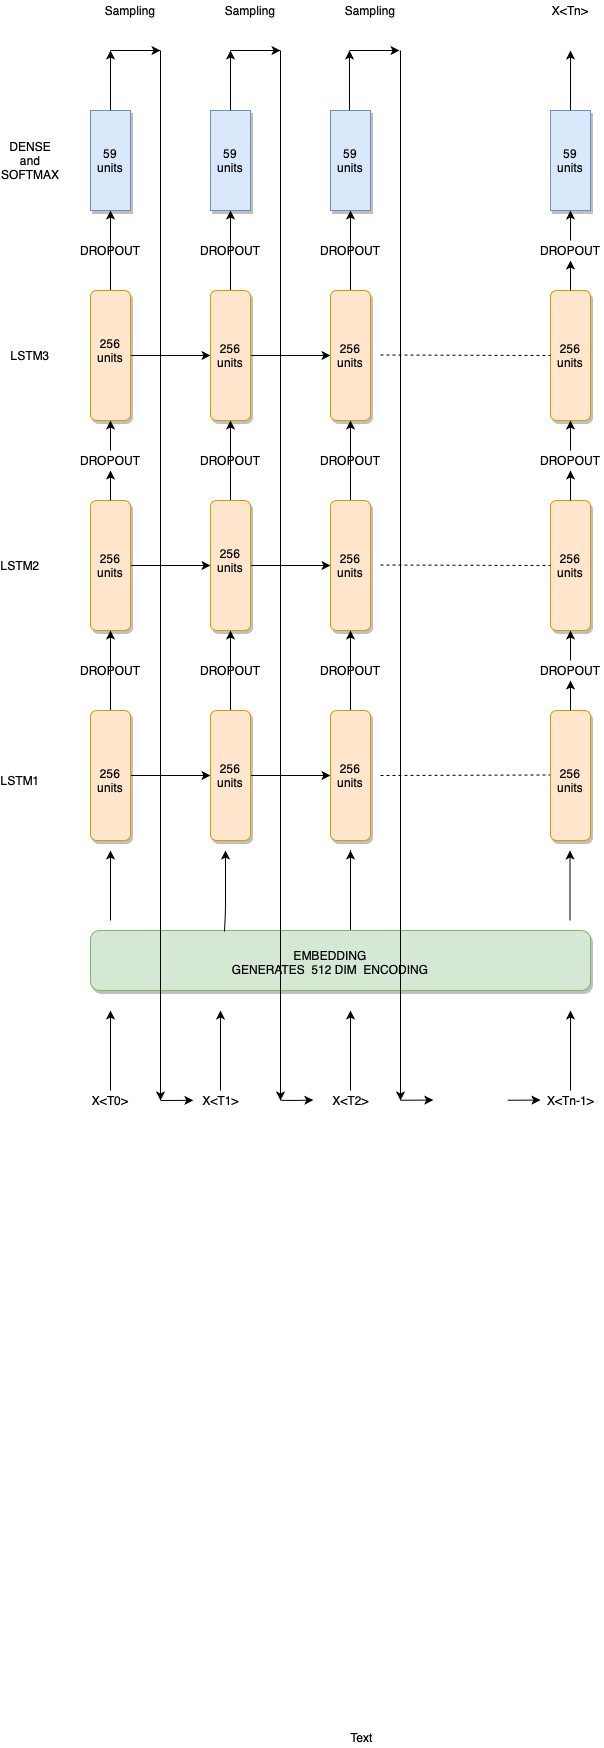

In [17]:
Image(filename='./drive/My Drive/generate.png') #image showing music generation model.

In [0]:
# Function which generates music sequences of length=gen_seq_length.
def generate_sequence(gen_seq_length):
    with open(os.path.join(data_directory, charIndex_json)) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    num_unique_chars = len(index_to_char)
    
    model = make_model(num_unique_chars)
    model.load_weights("./drive/My Drive/weights.80.hdf5")
     
    sequence_index = [char_to_index['Z']]

    for _ in range(gen_seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(num_unique_chars), size = 1, p = predicted_probs)
        
        
        sequence_index.append(sample[0])
    
        
    
    seq = ''.join(index_to_char[c] for c in sequence_index)
    seq='M:6/8\n'+str(seq)
    return seq

In [0]:
# function to create a midi file given a music sequence in abc notation.
def convert_to_midi(abc):
    c = converter.subConverters.ConverterABC()
    c.registerOutputExtensions = ("midi", )
    c.parseData(abc)
    s = c.stream
    s.write('midi', fp='demos1.mid')

In [20]:


file = open(os.path.join(data_directory, data_file), mode = 'r')
data = file.read()
file.close()
preprocess_data=preprocess(data)
all_characters_as_indices,num_unique_chars=read_data(preprocess_data)
X,Y=input_output(all_characters_as_indices,num_unique_chars)
print("length of preprocess_data-{}".format(len(preprocess_data)))
print("vocab_size={}".format(num_unique_chars))
print("all_characters={}".format(all_characters_as_indices))
print("length of all_characters-{}".format(len(all_characters_as_indices)))
print("shape of X={}".format(X.shape))
print("shape of Y={}".format(Y.shape))

length of preprocess_data-116963
vocab_size=59
all_characters=[33 44 57 ... 15 20 57]
length of all_characters-116963
shape of X=(1827, 64)
shape of Y=(1827, 64, 59)


In [0]:
model=build_model(SEQ_LENGTH,num_unique_chars)
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
checkpoint=ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5',monitor='loss',save_best_only=True,save_weights_only=True,period=1)
model.fit(X,Y,batch_size=16,epochs=80,callbacks=[checkpoint])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 512)           30208     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 256)          

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/80
1827/1827 [==============================] - 56s 31ms/step - loss: 3.0364 - accuracy: 0.1966
Epoch 2/80
1827/1827 [==============================] - 54s 30ms/step - loss: 2.1573 - accuracy: 0.3917
Epoch 3/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.8398 - accuracy: 0.4435
Epoch 4/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.6679 - accuracy: 0.4740
Epoch 5/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.5664 - accuracy: 0.4956
Epoch 6/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.4949 - accuracy: 0.5152
Epoch 7/80
1827/1827 [==============================] - 54s 30ms/step - loss: 1.4356 - accuracy: 0.5334
Epoch 8/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.3794 - accuracy: 0.5510
Epoch 9/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.3255 - accuracy: 0.5664
Epoch 10/80
1827/1827 [==============================] - 53s 29m

In [23]:
music = generate_sequence(192)
print("\nMUSIC SEQUENCE GENERATED: \n{}".format(music))
convert_to_midi(music)



MUSIC SEQUENCE GENERATED: 
M:6/8
ZD|"G"G2G BAG|"G"d2d d2d|"C"cBA "A7"B6|"D7"^c2d e3|"G"d2B d2B|
"Am"c2B A2B|"A7"c2c cBA|"D"e2d dBc|"D"d3 -d3|"G""g"g3 fgB|"Am"c3 "D7"c2d|
"G"e2d B^AB|"G"d2d BdB|"D"d2c "Em"B2c|"A7"A6|"D7"d3 ABc|


We have finished training and generating music sequences.